# Scaling Nonlinear Feature Selection using Random Fourier Feature–Based HSIC

Kernel-based dependence measures such as the Hilbert-Schmidt Independence Criterion (HSIC)
are powerful tools for nonlinear feature selection. However, their practical applicability
is limited by the quadratic memory and time complexity of kernel matrix construction.

This notebook investigates a scalable approximation of HSIC using Random Fourier Features
(RFF), enabling nonlinear dependence estimation through linear operations while preserving
statistical fidelity.

## 1. Problem Setup

The Hilbert-Schmidt Independence Criterion (HSIC) measures statistical dependence between
random variables by embedding them into a reproducing kernel Hilbert space. HSIC Lasso
leverages this property to perform nonlinear feature selection.

A major limitation of HSIC-based methods is the need to explicitly compute N × N kernel
matrices, resulting in O(N²) memory and time complexity. This restricts applicability
to small datasets.

In this work, we study a Random Fourier Feature (RFF) approximation of HSIC that avoids
explicit kernel computation and enables scalable dependence estimation.

In [2]:
import numpy as np
import pandas as pd
import time
import tracemalloc
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.kernel_approximation import RBFSampler


## 2. Baseline: Full HSIC (Small-N Only)

We first evaluate the standard kernel-based HSIC formulation on small datasets to
quantify its runtime and memory requirements. Due to explicit kernel matrix construction,
this baseline is only feasible for limited sample sizes.


In [3]:
def compute_hsic_full(X, y, sigma=1.0):
    """
    Full HSIC computation using RBF kernels.
    This implementation explicitly constructs N x N kernel matrices.
    Intended for small-N experiments only.
    """
    n = X.shape[0]

    K = rbf_kernel(X, X, gamma=1.0 / (2 * sigma ** 2))
    L = rbf_kernel(y.reshape(-1, 1), y.reshape(-1, 1),
                   gamma=1.0 / (2 * sigma ** 2))

    H = np.eye(n) - np.ones((n, n)) / n
    KH = H @ K @ H

    return np.trace(KH @ L) / ((n - 1) ** 2)


In [4]:
def benchmark_full_hsic(X, y, sigma=1.0):
    tracemalloc.start()
    start_time = time.time()

    hsic_value = compute_hsic_full(X, y, sigma=sigma)

    elapsed = time.time() - start_time
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return hsic_value, elapsed, peak / (1024 ** 2)


In [5]:
np.random.seed(0)

N_small = 500
D = 100

X_small = np.random.randn(N_small, D)
y_small = np.random.randn(N_small)

hsic_val, runtime, memory = benchmark_full_hsic(X_small, y_small)

print(f"Full HSIC (N={N_small})")
print(f"HSIC value : {hsic_val:.4f}")
print(f"Runtime    : {runtime:.3f} s")
print(f"Memory     : {memory:.2f} MB")


Full HSIC (N=500)
HSIC value : 0.0009
Runtime    : 0.059 s
Memory     : 9.55 MB


## 3. Random Fourier Feature Approximation for HSIC

Random Fourier Features provide a finite-dimensional approximation to shift-invariant
kernels based on Bochner’s theorem. Instead of constructing kernel matrices, data is
mapped into a randomized feature space where kernel evaluations are approximated by
inner products.

This enables HSIC computation using linear algebra, reducing memory complexity from
O(N²) to O(N·D), where D is the number of random features.


In [6]:
def compute_hsic_rff(X, y, n_features=300, sigma=1.0, random_state=0):
    n = X.shape[0]

    rff_x = RBFSampler(
        gamma=1.0 / (2 * sigma ** 2),
        n_components=n_features,
        random_state=random_state
    )
    Zx = rff_x.fit_transform(X)

    rff_y = RBFSampler(
        gamma=1.0 / (2 * sigma ** 2),
        n_components=n_features,
        random_state=random_state
    )
    Zy = rff_y.fit_transform(y.reshape(-1, 1))

    Zx -= Zx.mean(axis=0)
    Zy -= Zy.mean(axis=0)

    return np.linalg.norm(Zx.T @ Zy, ord="fro") ** 2 / (n ** 2)


In [7]:
def benchmark_rff_hsic(X, y, n_features=300, sigma=1.0):
    tracemalloc.start()
    start_time = time.time()

    hsic_value = compute_hsic_rff(X, y, n_features=n_features, sigma=sigma)

    elapsed = time.time() - start_time
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return hsic_value, elapsed, peak / (1024 ** 2)


In [8]:
X_test = np.random.randn(300, 50)
y_test = np.random.randn(300)

hsic_full = compute_hsic_full(X_test, y_test)
hsic_rff_100 = compute_hsic_rff(X_test, y_test, n_features=100)
hsic_rff_300 = compute_hsic_rff(X_test, y_test, n_features=300)

print("HSIC comparison (N=300)")
print(f"Full HSIC      : {hsic_full:.4f}")
print(f"RFF-HSIC (100) : {hsic_rff_100:.4f}")
print(f"RFF-HSIC (300) : {hsic_rff_300:.4f}")


HSIC comparison (N=300)
Full HSIC      : 0.0014
RFF-HSIC (100) : 0.0014
RFF-HSIC (300) : 0.0015


## 4. Scaling Experiments

We evaluate the scalability of the RFF-based HSIC approximation by measuring runtime
and memory usage across increasing sample sizes and feature dimensions.


In [9]:
def run_scaling_experiment(sample_sizes, rff_dims, input_dim=100):
    records = []

    for n in sample_sizes:
        X = np.random.randn(n, input_dim)
        y = np.random.randn(n)

        for d in rff_dims:
            _, runtime, memory = benchmark_rff_hsic(X, y, n_features=d)

            records.append({
                "num_samples": n,
                "rff_dim": d,
                "runtime_sec": runtime,
                "memory_mb": memory
            })

    return pd.DataFrame(records)


In [10]:
sample_sizes = [500, 1000, 2000, 5000]
rff_dims = [100, 300, 500]

df_scaling = run_scaling_experiment(sample_sizes, rff_dims)
df_scaling.to_csv("rff_hsic_scaling_results.csv", index=False)

df_scaling


,num_samples,rff_dim,runtime_sec,memory_mb
0,500,100,0.022409,0.920364
1,500,300,0.041434,3.213364
2,500,500,0.063767,6.117073
3,1000,100,0.033416,1.682838
4,1000,300,0.059982,5.502083
5,1000,500,0.097668,9.931717
6,2000,100,0.045547,3.208656
7,2000,300,0.113952,10.079659
8,2000,500,0.203125,17.561020
9,5000,100,0.113386,7.786240


## 5. Results and Visualization


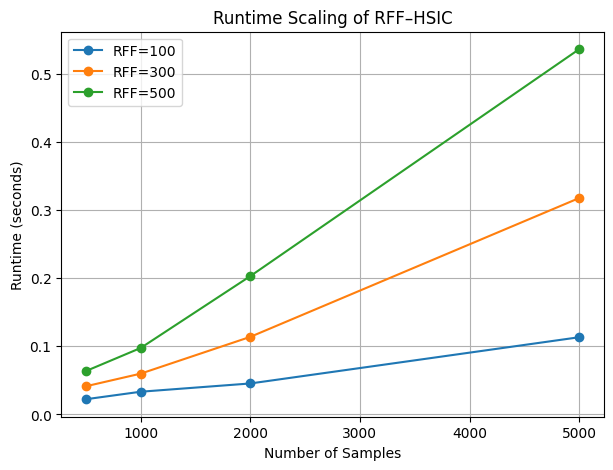

In [11]:
plt.figure(figsize=(7, 5))
for d in rff_dims:
    subset = df_scaling[df_scaling["rff_dim"] == d]
    plt.plot(subset["num_samples"], subset["runtime_sec"], marker="o", label=f"RFF={d}")

plt.xlabel("Number of Samples")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime Scaling of RFF–HSIC")
plt.legend()
plt.grid(True)
plt.savefig("runtime_vs_samples.png", dpi=300)
plt.show()


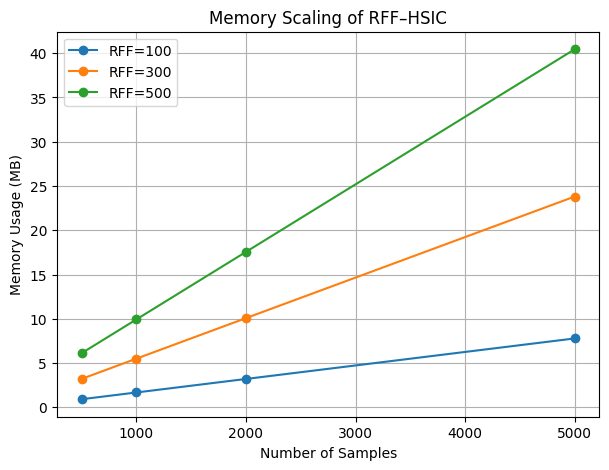

In [12]:
plt.figure(figsize=(7, 5))
for d in rff_dims:
    subset = df_scaling[df_scaling["rff_dim"] == d]
    plt.plot(subset["num_samples"], subset["memory_mb"], marker="o", label=f"RFF={d}")

plt.xlabel("Number of Samples")
plt.ylabel("Memory Usage (MB)")
plt.title("Memory Scaling of RFF–HSIC")
plt.legend()
plt.grid(True)
plt.savefig("memory_vs_samples.png", dpi=300)
plt.show()


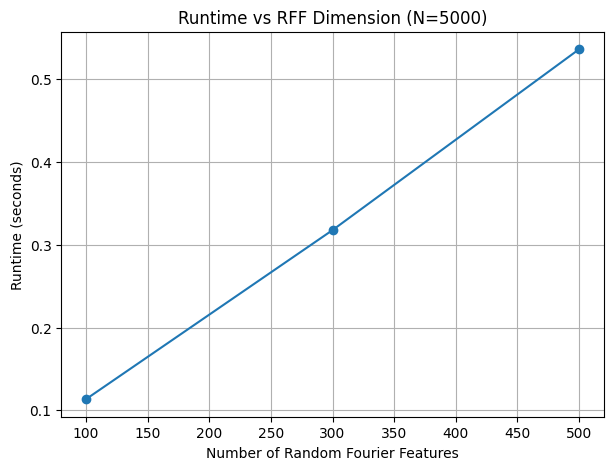

In [13]:
fixed_n = max(sample_sizes)
subset = df_scaling[df_scaling["num_samples"] == fixed_n]

plt.figure(figsize=(7, 5))
plt.plot(subset["rff_dim"], subset["runtime_sec"], marker="o")
plt.xlabel("Number of Random Fourier Features")
plt.ylabel("Runtime (seconds)")
plt.title(f"Runtime vs RFF Dimension (N={fixed_n})")
plt.grid(True)
plt.savefig("runtime_vs_rff_dim.png", dpi=300)
plt.show()


## 6. Discussion and Limitations

The results demonstrate that RFF-based HSIC significantly improves scalability by
avoiding explicit kernel matrix construction. Runtime and memory usage grow smoothly
with the number of samples, in contrast to the quadratic behavior of standard HSIC.

The approximation quality depends on the number of random features, introducing a
trade-off between efficiency and accuracy. This study focuses on synthetic data to
isolate scalability effects; extending the approach to real biological datasets and
structured regularization is left for future work.
